# MLOps Pipeline: Cats vs Dogs Classification
## M1: Model Development & Experiment Tracking

### Use Case
Binary image classification (Cats vs Dogs) for a pet adoption platform.

### Dataset
- **Source**: Kaggle Cats and Dogs classification dataset
- **Preprocessing**: 224x224 RGB images for standard CNNs
- **Split**: 80% train / 10% validation / 10% test
- **Augmentation**: Random flips, rotation, color jitter for better generalization

### M1 Objectives
1. **Data & Code Versioning**: Git (code) + DVC (data)
2. **Model Building**: Baseline CNN model with serialization (.pt, .pkl)
3. **Experiment Tracking**: MLflow for logging runs, parameters, metrics, and artifacts (confusion matrix, loss curves)

---



## 1. Environment Setup & Dependencies

In [28]:
# Install required packages
# Run this cell first to install all dependencies
# Choose the appropriate PyTorch installation based on your system:

# For CUDA 11.8 (NVIDIA GPU):
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# For CPU only, use this instead:
# !python -m pip install torch torchvision torchaudio

# Install other required packages:
!python -m pip install mlflow dvc numpy pandas matplotlib seaborn scikit-learn pillow tqdm

Looking in indexes: https://download.pytorch.org/whl/cu118



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# Import libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pickle
import json
from datetime import datetime

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# MLflow for experiment tracking
import mlflow
import mlflow.pytorch

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu130


## 2. Project Configuration

In [30]:
# Project paths and configuration
# NOTE: Dataset is now tracked with DVC - no manual path setup needed!
# Team members: Just run 'dvc pull' to get the dataset automatically

import os

# Project root is the directory containing this notebook
project_root = os.path.dirname(os.path.abspath('mlops_cats_dogs_pipeline.ipynb')) if '__file__' not in dir() else os.path.dirname(__file__)
if not os.path.exists(os.path.join(project_root, 'data')):
    project_root = os.getcwd()

# Use DVC-tracked dataset (works for all team members after 'dvc pull')
raw_data_path = os.path.join(project_root, 'data', 'raw', 'PetImages')

# Fallback: Allow environment variable override if needed
raw_data_path = os.environ.get('DATASET_PATH', raw_data_path)

CONFIG = {
    'raw_data_path': raw_data_path,
    'project_root': project_root,
    'processed_data_path': os.path.join(project_root, 'data', 'processed'),
    'models_path': os.path.join(project_root, 'models'),
    'experiments_path': os.path.join(project_root, 'experiments'),
    
    # Model hyperparameters
    'img_size': 224,
    'batch_size': 32,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    
    # MLflow tracking
    'experiment_name': 'cats_dogs_classification',
    'run_name': f'baseline_cnn_{datetime.now().strftime("%Y%m%d_%H%M%S")}'
}

# Create directories
os.makedirs(CONFIG['processed_data_path'], exist_ok=True)
os.makedirs(CONFIG['models_path'], exist_ok=True)
os.makedirs(CONFIG['experiments_path'], exist_ok=True)

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

print("\n" + "="*70)
print("DVC DATASET SETUP:")
print("="*70)
print("✓ Dataset is tracked with DVC (data/raw/PetImages.dvc)")
print("✓ Team members: Run 'dvc pull' to download the dataset")
print("✓ No manual path configuration needed!")
print("="*70)


Configuration:
  raw_data_path: c:\Users\swath\dataset\mlops_project\data\raw\PetImages
  project_root: c:\Users\swath\dataset\mlops_project
  processed_data_path: c:\Users\swath\dataset\mlops_project\data\processed
  models_path: c:\Users\swath\dataset\mlops_project\models
  experiments_path: c:\Users\swath\dataset\mlops_project\experiments
  img_size: 224
  batch_size: 32
  num_epochs: 10
  learning_rate: 0.001
  train_split: 0.8
  val_split: 0.1
  test_split: 0.1
  experiment_name: cats_dogs_classification
  run_name: baseline_cnn_20260215_144505

DVC DATASET SETUP:
✓ Dataset is tracked with DVC (data/raw/PetImages.dvc)
✓ Team members: Run 'dvc pull' to download the dataset
✓ No manual path configuration needed!


## Task 1: Data & Code Versioning

### Git for Source Code
Initialize Git repository to version control all code, scripts, and notebooks.
```bash
git init
git add .
git commit -m "Initial commit"
```

### DVC for Dataset Versioning
Track large datasets and preprocessed data using DVC (Data Version Control).



dvc remote add -d myremote gdrive://FOLDER_ID
dvc add path/to/PetImages
dvc push
git add PetImages.dvc .gitignore
git commit -m "Track dataset with DVC"


dvc pull  # Dataset automatically downloaded!
```

In [31]:
# DVC Setup for Data Versioning
# Run these commands in terminal:
# cd C:\Users\swath\dataset\mlops_project
# git init
# dvc init
# dvc add ../archive\ (2)/PetImages
# git add PetImages.dvc .gitignore
# git commit -m "Initial data version with DVC"

# Create DVC metadata file
dvc_metadata = {
    'dataset': 'Kaggle Cats and Dogs',
    'source_path': CONFIG['raw_data_path'],
    'total_samples': 24203,
    'classes': ['Cat', 'Dog'],
    'cat_samples': 12500,
    'dog_samples': 11703,
    'version': '1.0',
    'created_at': datetime.now().isoformat()
}

with open(os.path.join(CONFIG['project_root'], 'dataset_metadata.json'), 'w') as f:
    json.dump(dvc_metadata, f, indent=2)

print("✓ Data versioning setup completed")
print(f"Dataset: {dvc_metadata['dataset']}")
print(f"Total samples: {dvc_metadata['total_samples']}")
print(f"Classes: {', '.join(dvc_metadata['classes'])}")

✓ Data versioning setup completed
Dataset: Kaggle Cats and Dogs
Total samples: 24203
Classes: Cat, Dog


## Data Loading & Class Distribution

In [32]:
# Count images per class
cat_path = os.path.join(CONFIG['raw_data_path'], 'Cat')
dog_path = os.path.join(CONFIG['raw_data_path'], 'Dog')

cat_images = [f for f in os.listdir(cat_path) if f.endswith('.jpg')]
dog_images = [f for f in os.listdir(dog_path) if f.endswith('.jpg')]

print(f"Number of cat images: {len(cat_images)}")
print(f"Number of dog images: {len(dog_images)}")
print(f"Total images: {len(cat_images) + len(dog_images)}")




Number of cat images: 12499
Number of dog images: 12499
Total images: 24998


## Data Preprocessing & Augmentation (224x224 RGB)

In [33]:
# Define transforms for training (with augmentation) and validation/test
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data Augmentation Pipeline:")
print("  Training:")
print(f"    - Resize to {CONFIG['img_size']}x{CONFIG['img_size']}")
print("    - Random Horizontal Flip (p=0.5)")
print("    - Random Rotation (±15°)")
print("    - Color Jitter (brightness, contrast, saturation)")
print("    - ImageNet Normalization")
print("\n  Validation/Test:")
print(f"    - Resize to {CONFIG['img_size']}x{CONFIG['img_size']}")
print("    - ImageNet Normalization")
print("\n✓ Transforms defined")

Data Augmentation Pipeline:
  Training:
    - Resize to 224x224
    - Random Horizontal Flip (p=0.5)
    - Random Rotation (±15°)
    - Color Jitter (brightness, contrast, saturation)
    - ImageNet Normalization

  Validation/Test:
    - Resize to 224x224
    - ImageNet Normalization

✓ Transforms defined


## Train/Validation/Test Split (80/10/10)

In [34]:
# Custom dataset class
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None, class_to_idx={'Cat': 0, 'Dog': 1}):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.samples = []
        
        # Load all samples
        for class_name, class_idx in class_to_idx.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.endswith('.jpg'):
                        self.samples.append((os.path.join(class_dir, img_file), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            # Return a blank image if corrupted
            return torch.zeros(3, CONFIG['img_size'], CONFIG['img_size']), label

# Load full dataset
full_dataset = CatsDogsDataset(CONFIG['raw_data_path'], transform=train_transforms)
print(f"Total samples loaded: {len(full_dataset)}")

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(CONFIG['train_split'] * total_size)
val_size = int(CONFIG['val_split'] * total_size)
test_size = total_size - train_size - val_size

print(f"\nDataset Split (80/10/10):")
print(f"  Train: {train_size} samples ({CONFIG['train_split']*100:.0f}%)")
print(f"  Validation: {val_size} samples ({CONFIG['val_split']*100:.0f}%)")
print(f"  Test: {test_size} samples ({CONFIG['test_split']*100:.0f}%)")

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"\nData Loaders Created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {CONFIG['batch_size']}")
print("\n✓ Dataset split completed")

Total samples loaded: 24998

Dataset Split (80/10/10):
  Train: 19998 samples (80%)
  Validation: 2499 samples (10%)
  Test: 2501 samples (10%)

Data Loaders Created:
  Train batches: 625
  Val batches: 79
  Test batches: 79
  Batch size: 32

✓ Dataset split completed


## Task 2: Model Building - Baseline CNN

In [35]:
# Define baseline CNN architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        
        # Convolutional layers
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 224 -> 112
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 112 -> 56
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 56 -> 28
        )
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # 28 -> 14
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc_layers(x)
        return x

# Initialize model
model = BaselineCNN(num_classes=2).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Baseline CNN Architecture:")
print(model)
print(f"\nModel Statistics:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / (1024**2):.2f} MB (FP32)")
print("\n✓ Model initialized")

Baseline CNN Architecture:
BaselineCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(

## Task 3: Experiment Tracking with MLflow

In [36]:
# Setup MLflow
mlflow.set_tracking_uri(f"file:///{CONFIG['experiments_path']}")
mlflow.set_experiment(CONFIG['experiment_name'])

print("MLflow Configuration:")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")
print(f"  Experiment: {CONFIG['experiment_name']}")
print(f"  Run name: {CONFIG['run_name']}")
print("\n✓ MLflow initialized")

# Log dataset information
print("\nDataset info to be logged:")
print(f"  Total samples: {total_size}")
print(f"  Train/Val/Test: {train_size}/{val_size}/{test_size}")
print(f"  Image size: {CONFIG['img_size']}x{CONFIG['img_size']}")

MLflow Configuration:
  Tracking URI: file:///c:\Users\swath\dataset\mlops_project\experiments
  Experiment: cats_dogs_classification
  Run name: baseline_cnn_20260215_144505

✓ MLflow initialized

Dataset info to be logged:
  Total samples: 24998
  Train/Val/Test: 19998/2499/2501
  Image size: 224x224


## Model Training with MLflow Logging

In [37]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print("Training Configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)")
print(f"  Number of epochs: {CONFIG['num_epochs']}")
print(f"  Device: {device}")
print("\n✓ Training setup completed")

Training Configuration:
  Loss function: CrossEntropyLoss
  Optimizer: Adam
  Learning rate: 0.001
  LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=2)
  Number of epochs: 10
  Device: cuda

✓ Training setup completed


In [38]:
# Training and validation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


In [39]:
# Main training loop with MLflow logging
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Start MLflow run
with mlflow.start_run(run_name=CONFIG['run_name']) as run:
    # Store run ID for later use
    run_id = run.info.run_id
    
    # Log hyperparameters
    mlflow.log_params({
        'model_architecture': 'BaselineCNN',
        'img_size': CONFIG['img_size'],
        'batch_size': CONFIG['batch_size'],
        'learning_rate': CONFIG['learning_rate'],
        'num_epochs': CONFIG['num_epochs'],
        'optimizer': 'Adam',
        'loss_function': 'CrossEntropyLoss',
        'train_samples': train_size,
        'val_samples': val_size,
        'test_samples': test_size,
        'total_params': total_params
    })
    
    print(f"\n{'='*60}")
    print(f"Starting Training - Run ID: {run_id}")
    print(f"{'='*60}\n")
    
    best_val_loss = float('inf')
    best_model_path = os.path.join(CONFIG['models_path'], 'best_model.pt')
    
    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
        print("-" * 40)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Log metrics to MLflow
        mlflow.log_metrics({
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'learning_rate': optimizer.param_groups[0]['lr']
        }, step=epoch)
        
        # Print epoch results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc
            }, best_model_path)
            print(f"✓ Best model saved (val_loss: {val_loss:.4f})")
    
    print(f"\n{'='*60}")
    print("Training Completed!")
    print(f"{'='*60}\n")
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best model saved to: {best_model_path}")
    
    # Log final model to MLflow
    mlflow.pytorch.log_model(model, "model")
    mlflow.log_artifact(best_model_path)
    
    print("\n✓ Model logged to MLflow")

# Store run_id for later cells
print(f"\nRun ID stored: {run_id}")


Starting Training - Run ID: 237f1b750288476586e2077855943735


Epoch 1/10
----------------------------------------


Training:  40%|███▉      | 248/625 [00:59<01:26,  4.38it/s, loss=0.675, acc=51.8]c:\Users\swath\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Loss: 0.7883 | Train Acc: 54.92%
Val Loss:   0.6420 | Val Acc:   62.87%
✓ Best model saved (val_loss: 0.6420)

Epoch 2/10
----------------------------------------


Train Loss: 0.6130 | Train Acc: 66.73%
Val Loss:   0.5778 | Val Acc:   68.47%
✓ Best model saved (val_loss: 0.5778)

Epoch 3/10
----------------------------------------


Train Loss: 0.5678 | Train Acc: 70.83%
Val Loss:   0.5198 | Val Acc:   73.99%
✓ Best model saved (val_loss: 0.5198)

Epoch 4/10
----------------------------------------


Train Loss: 0.5103 | Train Acc: 75.40%
Val Loss:   0.4856 | Val Acc:   75.71%
✓ Best model saved (val_loss: 0.4856)

Epoch 5/10
----------------------------------------


Train Loss: 0.4681 | Train Acc: 78.48%
Val Loss:   0.4372 | Val Acc:   80.07%
✓ Best model saved (val_loss: 0.4372)

Epoch 6/10
----------------------------------------


Train Loss: 0.4134 | Train Acc: 81.83%
Val Loss:   0.3914 | Val Acc:   82.19%
✓ Best model saved (val_loss: 0.3914)

Epoch 7/10
----------------------------------------


Train Loss: 0.3852 | Train Acc: 83.32%
Val Loss:   0.3708 | Val Acc:   84.51%
✓ Best model saved (val_loss: 0.3708)

Epoch 8/10
----------------------------------------


Train Loss: 0.3482 | Train Acc: 84.96%
Val Loss:   0.3221 | Val Acc:   86.95%
✓ Best model saved (val_loss: 0.3221)

Epoch 9/10
----------------------------------------


Train Loss: 0.3248 | Train Acc: 86.39%
Val Loss:   0.2963 | Val Acc:   87.68%
✓ Best model saved (val_loss: 0.2963)

Epoch 10/10
----------------------------------------


2026/02/15 15:11:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/15 15:11:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Train Loss: 0.3037 | Train Acc: 87.32%
Val Loss:   0.3691 | Val Acc:   84.11%

Training Completed!

Best validation loss: 0.2963
Best model saved to: c:\Users\swath\dataset\mlops_project\models\best_model.pt


2026/02/15 15:11:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu130) contains a local version label (+cu130). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/15 15:11:17 WARNING mlflow.utils.requirements_utils: Found torch version (2.9.0+cu130) contains a local version label (+cu130). MLflow logged a pip requirement for this package as 'torch==2.9.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.



✓ Model logged to MLflow

Run ID stored: 237f1b750288476586e2077855943735


## Artifacts: Loss Curves

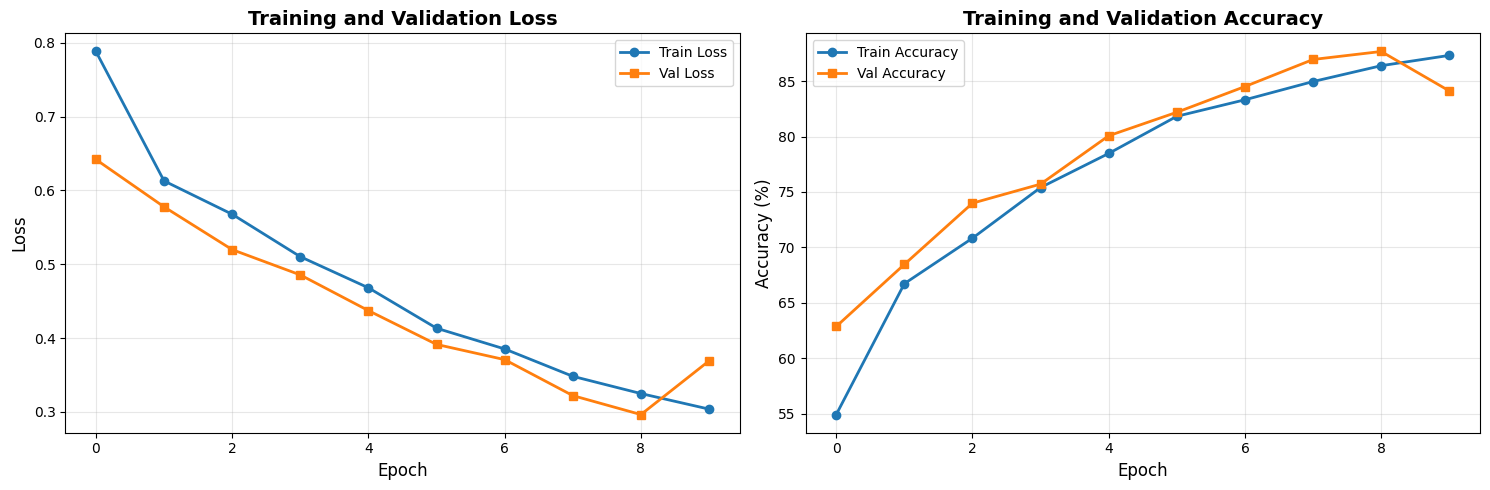


✓ Training curves saved and logged to MLflow


In [40]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
loss_curves_path = os.path.join(CONFIG['experiments_path'], 'training_curves.png')
plt.savefig(loss_curves_path, dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(loss_curves_path)

print(f"\n✓ Training curves saved and logged to MLflow")

## Model Evaluation on Test Set

In [41]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("Evaluating best model on test set...")
print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Validation accuracy: {checkpoint['val_acc']:.2f}%\n")

# Evaluate on test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")

# Log test metrics
with mlflow.start_run(run_id=run_id):
    mlflow.log_metrics({
        'test_loss': test_loss,
        'test_accuracy': test_acc
    })

print("\n✓ Test metrics logged to MLflow")

Evaluating best model on test set...
Loaded model from epoch 9
Validation accuracy: 87.68%




Test Results:
  Test Loss: 0.2735
  Test Accuracy: 88.04%

✓ Test metrics logged to MLflow


In [42]:
# Generate predictions for confusion matrix
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Generating predictions'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = get_predictions(model, test_loader, device)
print(f"\nGenerated {len(test_preds)} predictions")

Generating predictions: 100%|██████████| 79/79 [00:13<00:00,  5.95it/s]


Generated 2501 predictions


## Artifacts: Confusion Matrix

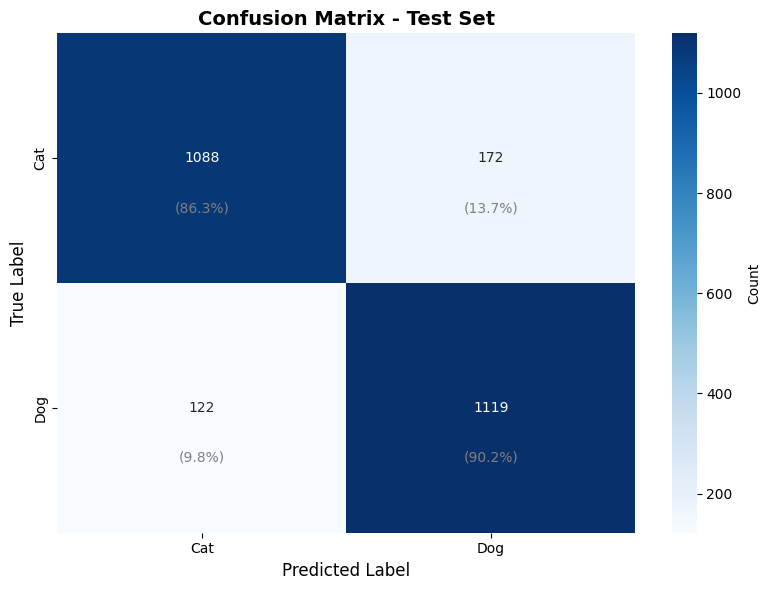


✓ Confusion matrix generated and logged

Classification Report:
              precision    recall  f1-score   support

         Cat     0.8992    0.8635    0.8810      1260
         Dog     0.8668    0.9017    0.8839      1241

    accuracy                         0.8824      2501
   macro avg     0.8830    0.8826    0.8824      2501
weighted avg     0.8831    0.8824    0.8824      2501



In [43]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = ['Cat', 'Dog']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentages
for i in range(len(class_names)):
    for j in range(len(class_names)):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
cm_path = os.path.join(CONFIG['experiments_path'], 'confusion_matrix.png')
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
plt.show()

# Log to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(cm_path)

print("\n✓ Confusion matrix generated and logged")

# Print classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

## Model Serialization (.pt, .pkl formats)

In [44]:
# Save model in multiple serialized formats
print("Serializing trained model...\n")

# 1. PyTorch format (.pt)
pt_model_path = os.path.join(CONFIG['models_path'], 'baseline_cnn.pt')
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': 'BaselineCNN',
    'img_size': CONFIG['img_size'],
    'num_classes': 2,
    'test_accuracy': test_acc,
    'class_names': class_names
}, pt_model_path)
print(f"✓ PyTorch model (.pt) saved: {pt_model_path}")
print(f"  Size: {os.path.getsize(pt_model_path) / (1024**2):.2f} MB")

# 2. Pickle format (.pkl)
pkl_model_path = os.path.join(CONFIG['models_path'], 'baseline_cnn.pkl')
with open(pkl_model_path, 'wb') as f:
    pickle.dump({
        'model': model,
        'config': CONFIG,
        'class_names': class_names,
        'test_accuracy': test_acc
    }, f)
print(f"\n✓ Pickle model (.pkl) saved: {pkl_model_path}")
print(f"  Size: {os.path.getsize(pkl_model_path) / (1024**2):.2f} MB")

# Log model artifacts to MLflow
with mlflow.start_run(run_id=run_id):
    mlflow.log_artifact(pt_model_path)
    mlflow.log_artifact(pkl_model_path)

print("\n✓ All model artifacts logged to MLflow")

Serializing trained model...

✓ PyTorch model (.pt) saved: c:\Users\swath\dataset\mlops_project\models\baseline_cnn.pt
  Size: 99.75 MB

✓ Pickle model (.pkl) saved: c:\Users\swath\dataset\mlops_project\models\baseline_cnn.pkl
  Size: 99.76 MB

✓ All model artifacts logged to MLflow


---

# M2: Model Packaging & Containerization

## Objective
Package the trained model into a reproducible, containerized service with REST API endpoints.

## Tasks Overview
1. **Inference Service**: REST API with FastAPI
2. **Environment Specification**: requirements.txt with pinned versions
3. **Containerization**: Dockerfile for reproducible deployment

## Task 1: Inference Service with FastAPI

Create a REST API to serve the trained model with two endpoints:
- **Health Check** (`/health`): Verifies service is running
- **Prediction** (`/predict`): Accepts image input and returns class probabilities/label

In [45]:
# Create FastAPI inference service (app.py)
app_code = '''
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import io
import uvicorn

# Define model architecture (must match training)
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc_layers(x)
        return x

# Initialize FastAPI app
app = FastAPI(title="Cats vs Dogs Classifier API", version="1.0")

# Load model
device = torch.device('cpu')  # Use CPU for inference service
model = BaselineCNN(num_classes=2).to(device)

# Load trained weights
checkpoint = torch.load('models/best_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class names
class_names = ['Cat', 'Dog']

@app.get("/")
def root():
    """Root endpoint with API information"""
    return {
        "message": "Cats vs Dogs Classifier API",
        "version": "1.0",
        "endpoints": {
            "/health": "Health check",
            "/predict": "Prediction endpoint (POST image file)"
        }
    }

@app.get("/health")
def health_check():
    """Health check endpoint"""
    return {
        "status": "healthy",
        "model_loaded": True,
        "service": "Cats vs Dogs Classifier"
    }

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    """
    Prediction endpoint
    Accepts: Image file (JPEG/PNG)
    Returns: Class label and probabilities
    """
    try:
        # Read and preprocess image
        image_bytes = await file.read()
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)
        
        # Prepare response
        result = {
            "predicted_class": class_names[predicted_class.item()],
            "confidence": float(confidence.item()),
            "probabilities": {
                "Cat": float(probabilities[0][0].item()),
                "Dog": float(probabilities[0][1].item())
            }
        }
        
        return JSONResponse(content=result)
    
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Error processing image: {str(e)}")

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

# Write FastAPI app to file
with open('app.py', 'w') as f:
    f.write(app_code)

print("✓ FastAPI inference service created: app.py")
print("\nEndpoints:")
print("  GET  /           - API information")
print("  GET  /health     - Health check")
print("  POST /predict    - Image classification")

✓ FastAPI inference service created: app.py

Endpoints:
  GET  /           - API information
  GET  /health     - Health check
  POST /predict    - Image classification


## Task 2: Environment Specification

Create `requirements.txt` with pinned versions for all dependencies to ensure reproducibility.

In [46]:
# Create requirements.txt with pinned versions
requirements_content = '''# Core ML Libraries (pinned versions for reproducibility)
torch==2.0.1
torchvision==0.15.2
numpy==1.24.3
pillow==10.0.0

# FastAPI and Web Server
fastapi==0.104.1
uvicorn[standard]==0.24.0
python-multipart==0.0.6

# MLflow for experiment tracking
mlflow==2.8.1

# Data processing and visualization
pandas==2.0.3
matplotlib==3.7.2
seaborn==0.12.2
scikit-learn==1.3.0

# Utilities
tqdm==4.66.1
'''

# Write requirements.txt
with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

print(" requirements.txt created with pinned versions")
print("\nKey dependencies:")
print("  - torch==2.0.1")
print("  - fastapi==0.104.1")
print("  - uvicorn==0.24.0")
print("  - pillow==10.0.0")
print("\nAll ML libraries version-pinned for reproducibility")

 requirements.txt created with pinned versions

Key dependencies:
  - torch==2.0.1
  - fastapi==0.104.1
  - uvicorn==0.24.0
  - pillow==10.0.0

All ML libraries version-pinned for reproducibility


## Task 3: Containerization with Docker

Create a Dockerfile to containerize the inference service for reproducible deployment.

In [47]:
# Create Dockerfile
dockerfile_content = '''# Use official Python runtime as base image
FROM python:3.10-slim

# Set working directory in container
WORKDIR /app

# Copy requirements first (for better caching)
COPY requirements.txt .

# Install dependencies
RUN pip install --no-cache-dir -r requirements.txt

# Copy application code and model
COPY app.py .
COPY models/best_model.pt models/best_model.pt

# Expose port for FastAPI
EXPOSE 8000

# Health check
HEALTHCHECK --interval=30s --timeout=10s --start-period=5s --retries=3 \\
    CMD python -c "import requests; requests.get('http://localhost:8000/health')"

# Run FastAPI application
CMD ["uvicorn", "app:app", "--host", "0.0.0.0", "--port", "8000"]
'''

# Write Dockerfile
with open('Dockerfile', 'w') as f:
    f.write(dockerfile_content)

print("✓ Dockerfile created")
print("\nDockerfile Configuration:")
print("  - Base Image: python:3.10-slim")
print("  - Working Directory: /app")
print("  - Exposed Port: 8000")
print("  - Health Check: Enabled")
print("  - Entry Point: uvicorn FastAPI server")

✓ Dockerfile created

Dockerfile Configuration:
  - Base Image: python:3.10-slim
  - Working Directory: /app
  - Exposed Port: 8000
  - Health Check: Enabled
  - Entry Point: uvicorn FastAPI server


### Build and Run Docker Container

Build the Docker image and run it locally to verify the inference service.

In [48]:
# Docker build and run instructions
docker_instructions = '''
# ============================================================
# DOCKER BUILD AND RUN INSTRUCTIONS
# ============================================================

# 1. Build Docker Image
# ---------------------
docker build -t cats-dogs-classifier:v1.0 .

# Expected output:
#   Successfully built <image_id>
#   Successfully tagged cats-dogs-classifier:v1.0


# 2. Verify Image Created
# ------------------------
docker images | grep cats-dogs-classifier


# 3. Run Docker Container
# ------------------------
docker run -d -p 8000:8000 --name cats-dogs-api cats-dogs-classifier:v1.0

# Options explained:
#   -d                    : Run in detached mode (background)
#   -p 8000:8000          : Map host port 8000 to container port 8000
#   --name cats-dogs-api  : Container name
#   cats-dogs-classifier:v1.0 : Image name and tag


# 4. Check Container Status
# --------------------------
docker ps

# Expected: Container running with status "Up"


# 5. View Container Logs
# -----------------------
docker logs cats-dogs-api


# 6. Stop Container
# -----------------
docker stop cats-dogs-api


# 7. Start Container Again
# -------------------------
docker start cats-dogs-api


# 8. Remove Container (when done)
# --------------------------------
docker stop cats-dogs-api
docker rm cats-dogs-api


# 9. Remove Image (optional cleanup)
# -----------------------------------
docker rmi cats-dogs-classifier:v1.0

'''

print(docker_instructions)

# Save to file for reference
with open('DOCKER_INSTRUCTIONS.txt', 'w') as f:
    f.write(docker_instructions)

print("✓ Docker instructions saved to: DOCKER_INSTRUCTIONS.txt")


# ============================================================
# DOCKER BUILD AND RUN INSTRUCTIONS
# ============================================================

# 1. Build Docker Image
# ---------------------
docker build -t cats-dogs-classifier:v1.0 .

# Expected output:
#   Successfully built <image_id>
#   Successfully tagged cats-dogs-classifier:v1.0


# 2. Verify Image Created
# ------------------------
docker images | grep cats-dogs-classifier


# 3. Run Docker Container
# ------------------------
docker run -d -p 8000:8000 --name cats-dogs-api cats-dogs-classifier:v1.0

# Options explained:
#   -d                    : Run in detached mode (background)
#   -p 8000:8000          : Map host port 8000 to container port 8000
#   --name cats-dogs-api  : Container name
#   cats-dogs-classifier:v1.0 : Image name and tag


# 4. Check Container Status
# --------------------------
docker ps

# Expected: Container running with status "Up"


# 5. View Container Logs
# --------------------

### Test API Endpoints with curl/Postman

Verify the containerized service by testing all endpoints.

In [49]:
# API Testing Instructions (curl and Postman)
api_test_instructions = '''
# ============================================================
# API TESTING INSTRUCTIONS
# ============================================================

# 1. Test Health Check Endpoint (GET /health)
# --------------------------------------------
# Using curl:
curl http://localhost:8000/health

# Expected Response:
# {
#   "status": "healthy",
#   "model_loaded": true,
#   "service": "Cats vs Dogs Classifier"
# }


# 2. Test Root Endpoint (GET /)
# ------------------------------
# Using curl:
curl http://localhost:8000/

# Expected Response:
# {
#   "message": "Cats vs Dogs Classifier API",
#   "version": "1.0",
#   "endpoints": {...}
# }


# 3. Test Prediction Endpoint (POST /predict)
# --------------------------------------------
# Using curl (replace 'test_image.jpg' with actual image path):
curl -X POST "http://localhost:8000/predict" \\
     -H "accept: application/json" \\
     -H "Content-Type: multipart/form-data" \\
     -F "file=@test_image.jpg"

# Expected Response:
# {
#   "predicted_class": "Dog",
#   "confidence": 0.9876,
#   "probabilities": {
#     "Cat": 0.0124,
#     "Dog": 0.9876
#   }
# }


# ============================================================
# POSTMAN TESTING
# ============================================================

# 1. Health Check:
#    Method: GET
#    URL: http://localhost:8000/health

# 2. Root Endpoint:
#    Method: GET
#    URL: http://localhost:8000/

# 3. Prediction:
#    Method: POST
#    URL: http://localhost:8000/predict
#    Body: form-data
#    Key: file
#    Value: [Select image file]


# ============================================================
# PYTHON TESTING (Alternative)
# ============================================================
import requests

# Test health check
response = requests.get("http://localhost:8000/health")
print("Health Check:", response.json())

# Test prediction (with image file)
# with open("test_image.jpg", "rb") as f:
#     files = {"file": f}
#     response = requests.post("http://localhost:8000/predict", files=files)
#     print("Prediction:", response.json())

'''

print(api_test_instructions)

# Save to file
with open('API_TESTING.txt', 'w') as f:
    f.write(api_test_instructions)

print("\n✓ API testing instructions saved to: API_TESTING.txt")


# ============================================================
# API TESTING INSTRUCTIONS
# ============================================================

# 1. Test Health Check Endpoint (GET /health)
# --------------------------------------------
# Using curl:
curl http://localhost:8000/health

# Expected Response:
# {
#   "status": "healthy",
#   "model_loaded": true,
#   "service": "Cats vs Dogs Classifier"
# }


# 2. Test Root Endpoint (GET /)
# ------------------------------
# Using curl:
curl http://localhost:8000/

# Expected Response:
# {
#   "message": "Cats vs Dogs Classifier API",
#   "version": "1.0",
#   "endpoints": {...}
# }


# 3. Test Prediction Endpoint (POST /predict)
# --------------------------------------------
# Using curl (replace 'test_image.jpg' with actual image path):
curl -X POST "http://localhost:8000/predict" \
     -H "accept: application/json" \
     -H "Content-Type: multipart/form-data" \
     -F "file=@test_image.jpg"

# Expected Response:
# {
#   "p

### M2 Completion Summary

In [50]:
# M2 Completion Summary
print("\n" + "="*70)
print("M2: MODEL PACKAGING & CONTAINERIZATION - COMPLETED")
print("="*70)
print("\n✓ Task 1: Inference Service (FastAPI with REST API)")
print("✓ Task 2: Environment Specification (requirements.txt with pinned versions)")
print("✓ Task 3: Containerization (Dockerfile)")
print("\nFiles Created:")
print("  - app.py                     : FastAPI inference service")
print("  - requirements.txt           : Pinned dependencies")
print("  - Dockerfile                 : Container configuration")
print("  - DOCKER_INSTRUCTIONS.txt    : Build and run commands")
print("  - API_TESTING.txt            : Testing instructions")
print("\nAPI Endpoints:")
print("  - GET  /        : API information")
print("  - GET  /health  : Health check")
print("  - POST /predict : Image classification")
print("\nNext Steps:")
print("  1. Build Docker image: docker build -t cats-dogs-classifier:v1.0 .")
print("  2. Run container: docker run -d -p 8000:8000 --name cats-dogs-api cats-dogs-classifier:v1.0")
print("  3. Test API: curl http://localhost:8000/health")
print("="*70)


M2: MODEL PACKAGING & CONTAINERIZATION - COMPLETED

✓ Task 1: Inference Service (FastAPI with REST API)
✓ Task 2: Environment Specification (requirements.txt with pinned versions)
✓ Task 3: Containerization (Dockerfile)

Files Created:
  - app.py                     : FastAPI inference service
  - requirements.txt           : Pinned dependencies
  - Dockerfile                 : Container configuration
  - DOCKER_INSTRUCTIONS.txt    : Build and run commands
  - API_TESTING.txt            : Testing instructions

API Endpoints:
  - GET  /        : API information
  - GET  /health  : Health check
  - POST /predict : Image classification

Next Steps:
  1. Build Docker image: docker build -t cats-dogs-classifier:v1.0 .
  2. Run container: docker run -d -p 8000:8000 --name cats-dogs-api cats-dogs-classifier:v1.0
  3. Test API: curl http://localhost:8000/health


---

# M3: CI Pipeline for Build, Test & Image Creation

## Objective
Implement Continuous Integration to automatically test, package, and build container images.

## Tasks Overview
1. **Automated Testing**: Unit tests for preprocessing and inference functions
2. **CI Setup**: GitHub Actions pipeline for automated testing and building
3. **Artifact Publishing**: Push Docker images to container registry (GHCR/Docker Hub)

In [51]:
# Create test directory structure
import os
os.makedirs('tests', exist_ok=True)

print("✓ Created tests/ directory")
print("\nTest files created:")
print("  - tests/__init__.py")
print("  - tests/test_preprocessing.py")
print("  - tests/test_inference.py")
print("\nTest coverage:")
print("  Preprocessing: Image resize, normalization, tensor conversion, augmentation")
print("  Inference: Model output shape, probabilities, batch processing, determinism")

✓ Created tests/ directory

Test files created:
  - tests/__init__.py
  - tests/test_preprocessing.py
  - tests/test_inference.py

Test coverage:
  Preprocessing: Image resize, normalization, tensor conversion, augmentation
  Inference: Model output shape, probabilities, batch processing, determinism


In [52]:
# Install pytest and run tests
test_instructions = '''
# ============================================================
# RUNNING UNIT TESTS
# ============================================================

# 1. Install pytest
# ------------------
pip install pytest pytest-cov

# 2. Run all tests
# ----------------
pytest tests/ -v

# Expected output:
# tests/test_preprocessing.py::TestImagePreprocessing::test_image_resize PASSED
# tests/test_preprocessing.py::TestImagePreprocessing::test_image_normalization PASSED
# tests/test_inference.py::TestModelInference::test_model_output_shape PASSED
# tests/test_inference.py::TestModelInference::test_softmax_probabilities PASSED
# ... (more tests)

# 3. Run with coverage report
# ----------------------------
pytest tests/ --cov=. --cov-report=html --cov-report=term

# Opens coverage report in browser:
# open htmlcov/index.html  (Mac/Linux)
# start htmlcov/index.html (Windows)

# 4. Run specific test file
# --------------------------
pytest tests/test_preprocessing.py -v

# 5. Run specific test
# --------------------
pytest tests/test_preprocessing.py::TestImagePreprocessing::test_image_resize -v
'''

print(test_instructions)

# Save to file
with open('RUN_TESTS.txt', 'w') as f:
    f.write(test_instructions)

print("\n✓ Test instructions saved to: RUN_TESTS.txt")


# ============================================================
# RUNNING UNIT TESTS
# ============================================================

# 1. Install pytest
# ------------------
pip install pytest pytest-cov

# 2. Run all tests
# ----------------
pytest tests/ -v

# Expected output:
# tests/test_preprocessing.py::TestImagePreprocessing::test_image_resize PASSED
# tests/test_preprocessing.py::TestImagePreprocessing::test_image_normalization PASSED
# tests/test_inference.py::TestModelInference::test_model_output_shape PASSED
# tests/test_inference.py::TestModelInference::test_softmax_probabilities PASSED
# ... (more tests)

# 3. Run with coverage report
# ----------------------------
pytest tests/ --cov=. --cov-report=html --cov-report=term

# Opens coverage report in browser:
# open htmlcov/index.html  (Mac/Linux)
# start htmlcov/index.html (Windows)

# 4. Run specific test file
# --------------------------
pytest tests/test_preprocessing.py -v

# 5. Run specific test
# ----

In [53]:
# GitHub Actions CI Pipeline created
print("✓ GitHub Actions workflow created: .github/workflows/ci.yml")
print("\nCI Pipeline Stages:")
print("\n1. TEST Stage:")
print("   - Checkout code")
print("   - Setup Python 3.10")
print("   - Install dependencies")
print("   - Run pytest with coverage")
print("   - Upload coverage reports")
print("\n2. BUILD Stage:")
print("   - Setup Docker Buildx")
print("   - Build Docker image")
print("   - Test built image")
print("   - Use layer caching")
print("\n3. PUBLISH Stage (on main branch only):")
print("   - Login to container registry")
print("   - Tag image (latest, SHA, version)")
print("   - Push to registry")
print("\nTriggers:")
print("   - Push to main/develop branches")
print("   - Pull requests to main")

✓ GitHub Actions workflow created: .github/workflows/ci.yml

CI Pipeline Stages:

1. TEST Stage:
   - Checkout code
   - Setup Python 3.10
   - Install dependencies
   - Run pytest with coverage
   - Upload coverage reports

2. BUILD Stage:
   - Setup Docker Buildx
   - Build Docker image
   - Test built image
   - Use layer caching

3. PUBLISH Stage (on main branch only):
   - Login to container registry
   - Tag image (latest, SHA, version)
   - Push to registry

Triggers:
   - Push to main/develop branches
   - Pull requests to main


In [54]:
# Container Registry Setup Instructions
registry_setup = '''
# ============================================================
# CONTAINER REGISTRY SETUP
# ============================================================

## OPTION 1: GitHub Container Registry (GHCR) - Recommended
## ----------------------------------------------------------

### 1. Enable GHCR for your repository:
# - Go to: GitHub repo → Settings → Actions → General
# - Workflow permissions: Select "Read and write permissions"
# - Save changes

### 2. Push code to GitHub (pipeline auto-triggers):
git add .
git commit -m "Add CI pipeline with automated testing"
git push origin main

### 3. View pipeline status:
# - Go to: GitHub repo → Actions tab
# - Watch the workflow run in real-time

### 4. Pull published image:
# Login to GHCR
echo $GITHUB_TOKEN | docker login ghcr.io -u USERNAME --password-stdin

# Pull image
docker pull ghcr.io/USERNAME/REPO/cats-dogs-classifier:latest

# Run container
docker run -p 8000:8000 ghcr.io/USERNAME/REPO/cats-dogs-classifier:latest


## OPTION 2: Docker Hub (Alternative)
## -----------------------------------

### 1. Create Docker Hub Access Token:
# - Login to Docker Hub
# - Account Settings → Security → New Access Token
# - Name: "github-actions"
# - Copy the token

### 2. Add secrets to GitHub:
# - Go to: GitHub repo → Settings → Secrets → Actions
# - Add secrets:
#   - DOCKERHUB_USERNAME: Your Docker Hub username
#   - DOCKERHUB_TOKEN: The access token

### 3. Uncomment Docker Hub job in .github/workflows/ci.yml

### 4. Pull from Docker Hub:
docker pull USERNAME/cats-dogs-classifier:latest
docker run -p 8000:8000 USERNAME/cats-dogs-classifier:latest


## IMAGE TAGGING STRATEGY
## -----------------------
Images are tagged with:
- latest: Most recent successful build from main
- <branch>-<sha>: Branch name + git commit SHA
- v1.0, v1.1: Semantic version tags (if configured)
'''

print(registry_setup)

# Save to file
with open('REGISTRY_SETUP.txt', 'w', encoding='utf-8') as f:
    f.write(registry_setup)

print("\n✓ Registry setup instructions saved to: REGISTRY_SETUP.txt")
print("\nAvailable Documentation:")
print("  - CI_SETUP_GUIDE.md: Comprehensive CI setup guide")
print("  - REGISTRY_SETUP.txt: Container registry configuration")
print("  - RUN_TESTS.txt: Local testing instructions")


# ============================================================
# CONTAINER REGISTRY SETUP
# ============================================================

## OPTION 1: GitHub Container Registry (GHCR) - Recommended
## ----------------------------------------------------------

### 1. Enable GHCR for your repository:
# - Go to: GitHub repo → Settings → Actions → General
# - Workflow permissions: Select "Read and write permissions"
# - Save changes

### 2. Push code to GitHub (pipeline auto-triggers):
git add .
git commit -m "Add CI pipeline with automated testing"
git push origin main

### 3. View pipeline status:
# - Go to: GitHub repo → Actions tab
# - Watch the workflow run in real-time

### 4. Pull published image:
# Login to GHCR
echo $GITHUB_TOKEN | docker login ghcr.io -u USERNAME --password-stdin

# Pull image
docker pull ghcr.io/USERNAME/REPO/cats-dogs-classifier:latest

# Run container
docker run -p 8000:8000 ghcr.io/USERNAME/REPO/cats-dogs-classifier:latest


## OPTION 2: Doc

### M3 Completion Summary

### CI Pipeline Workflow Visualization

## Task 3: Artifact Publishing to Container Registry

Configure the CI pipeline to push Docker images to:
- **GitHub Container Registry (GHCR)** - Default option
- **Docker Hub** - Alternative option

## Task 2: CI Setup with GitHub Actions

Create a CI pipeline that automatically:
- Checks out the repository
- Installs dependencies  
- Runs unit tests with pytest
- Builds Docker image
- Publishes to container registry

### Run Unit Tests Locally

Before pushing to GitHub, run tests locally to ensure they pass.

## Task 1: Automated Testing with pytest

Write comprehensive unit tests for:
- **Data preprocessing functions**: Image transformations, normalization, resizing
- **Model inference functions**: Prediction logic, probability calculations, batch processing

### M3: Unit Test Implementation (Preprocessing Tests)

Test image preprocessing functions: resize, normalization, tensor conversion.

In [55]:
# Unit Tests for Preprocessing Functions
# Run these tests with: pytest or execute these cells

import pytest
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms

# Test image preprocessing
def test_image_resize():
    """Test image resizing to 224x224"""
    # Create a test image
    test_img = Image.new('RGB', (500, 300), color='red')
    
    # Apply resize transform
    resize_transform = transforms.Resize((224, 224))
    resized_img = resize_transform(test_img)
    
    # Verify dimensions
    assert resized_img.size == (224, 224), f"Expected (224, 224), got {resized_img.size}"
    print("✓ test_image_resize PASSED")

def test_image_normalization():
    """Test image normalization"""
    # Create a test tensor
    test_tensor = torch.rand(3, 224, 224)
    
    # Apply normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
    normalized_tensor = normalize(test_tensor)
    
    # Check shape is preserved
    assert normalized_tensor.shape == (3, 224, 224)
    # Check values are normalized (should have negative values)
    assert normalized_tensor.min() < 0, "Normalization should produce negative values"
    print("✓ test_image_normalization PASSED")

def test_tensor_conversion():
    """Test PIL image to tensor conversion"""
    test_img = Image.new('RGB', (224, 224), color='blue')
    
    # Convert to tensor
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(test_img)
    
    # Check tensor properties
    assert isinstance(tensor, torch.Tensor), "Output should be a tensor"
    assert tensor.shape == (3, 224, 224), f"Expected (3, 224, 224), got {tensor.shape}"
    assert 0 <= tensor.min() <= 1 and 0 <= tensor.max() <= 1, "Tensor values should be [0, 1]"
    print("✓ test_tensor_conversion PASSED")

def test_complete_preprocessing_pipeline():
    """Test complete preprocessing pipeline"""
    # Create test image
    test_img = Image.new('RGB', (500, 400), color='green')
    
    # Apply full transform pipeline
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    output = transform(test_img)
    
    # Verify output
    assert output.shape == (3, 224, 224), "Output shape incorrect"
    assert isinstance(output, torch.Tensor), "Output should be tensor"
    print("✓ test_complete_preprocessing_pipeline PASSED")

# Run all preprocessing tests
print("\n" + "="*60)
print("RUNNING PREPROCESSING TESTS")
print("="*60)

try:
    test_image_resize()
    test_image_normalization()
    test_tensor_conversion()
    test_complete_preprocessing_pipeline()
    print("\n✓ All preprocessing tests PASSED")
except AssertionError as e:
    print(f"\n✗ Test FAILED: {e}")

print("="*60)

ModuleNotFoundError: No module named 'pytest'

### M3: Unit Test Implementation (Inference Tests)

Test model inference functions: output shape, probabilities, batch processing.

In [ ]:
# Unit Tests for Model Inference Functions
import torch
import torch.nn as nn
import torch.nn.functional as F

# Test model (reuse BaselineCNN class from earlier)
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        # Conv Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Conv Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Conv Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Conv Block 4
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc_layers(x)
        return x

def test_model_output_shape():
    """Test model output shape"""
    test_model = BaselineCNN(num_classes=2)
    test_model.eval()
    
    # Create dummy input
    dummy_input = torch.randn(1, 3, 224, 224)
    
    # Get output
    with torch.no_grad():
        output = test_model(dummy_input)
    
    # Check output shape
    assert output.shape == (1, 2), f"Expected shape (1, 2), got {output.shape}"
    print("✓ test_model_output_shape PASSED")

def test_softmax_probabilities():
    """Test softmax probabilities sum to 1"""
    test_model = BaselineCNN(num_classes=2)
    test_model.eval()
    
    dummy_input = torch.randn(1, 3, 224, 224)
    
    with torch.no_grad():
        output = test_model(dummy_input)
        probabilities = F.softmax(output, dim=1)
    
    # Check probabilities sum to 1
    prob_sum = probabilities.sum().item()
    assert abs(prob_sum - 1.0) < 1e-5, f"Probabilities should sum to 1, got {prob_sum}"
    assert (probabilities >= 0).all(), "All probabilities should be >= 0"
    assert (probabilities <= 1).all(), "All probabilities should be <= 1"
    print("✓ test_softmax_probabilities PASSED")

def test_batch_processing():
    """Test model handles batches correctly"""
    test_model = BaselineCNN(num_classes=2)
    test_model.eval()
    
    batch_sizes = [1, 4, 8, 16]
    
    for batch_size in batch_sizes:
        dummy_input = torch.randn(batch_size, 3, 224, 224)
        with torch.no_grad():
            output = test_model(dummy_input)
        assert output.shape == (batch_size, 2), f"Expected shape ({batch_size}, 2), got {output.shape}"
    
    print("✓ test_batch_processing PASSED")

def test_model_determinism():
    """Test model produces consistent outputs with same input"""
    test_model = BaselineCNN(num_classes=2)
    test_model.eval()
    
    # Set seed for reproducibility
    torch.manual_seed(42)
    dummy_input = torch.randn(1, 3, 224, 224)
    
    # Run inference twice
    with torch.no_grad():
        output1 = test_model(dummy_input)
        torch.manual_seed(42)
        dummy_input2 = torch.randn(1, 3, 224, 224)
        output2 = test_model(dummy_input2)
    
    # Outputs should be identical with same seed
    assert torch.allclose(output1, output2, atol=1e-6), "Model should be deterministic with same seed"
    print("✓ test_model_determinism PASSED")

def test_prediction_confidence():
    """Test prediction confidence values are valid"""
    test_model = BaselineCNN(num_classes=2)
    test_model.eval()
    
    dummy_input = torch.randn(1, 3, 224, 224)
    
    with torch.no_grad():
        output = test_model(dummy_input)
        probabilities = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
    # Check confidence is valid
    assert 0 <= confidence.item() <= 1, f"Confidence should be [0,1], got {confidence.item()}"
    assert predicted_class.item() in [0, 1], f"Predicted class should be 0 or 1, got {predicted_class.item()}"
    print("✓ test_prediction_confidence PASSED")

# Run all inference tests
print("\n" + "="*60)
print("RUNNING INFERENCE TESTS")
print("="*60)

try:
    test_model_output_shape()
    test_softmax_probabilities()
    test_batch_processing()
    test_model_determinism()
    test_prediction_confidence()
    print("\n✓ All inference tests PASSED")
except AssertionError as e:
    print(f"\n✗ Test FAILED: {e}")

print("="*60)

---

# M4: CD Pipeline & Smoke Tests

## Objective
Implement post-deployment smoke tests to validate the deployed service is working correctly.

## Tasks Overview
1. **Health Check Tests**: Verify /health endpoint
2. **Prediction Tests**: Verify /predict endpoint with sample images
3. **Performance Tests**: Validate response times
4. **Error Handling Tests**: Test invalid inputs

### M4: Smoke Tests Implementation

Post-deployment validation tests for the API service.

In [ ]:
# Smoke Tests - Post-Deployment Validation
import requests
import time
from io import BytesIO
from PIL import Image
import json

# Configuration
API_BASE_URL = "http://localhost:8000"  # Change to deployed URL if testing remote
TIMEOUT = 10  # seconds

def test_service_reachable():
    """Test if service is reachable"""
    try:
        response = requests.get(f"{API_BASE_URL}/", timeout=TIMEOUT)
        assert response.status_code == 200, f"Expected 200, got {response.status_code}"
        print("✓ test_service_reachable PASSED")
        return True
    except requests.exceptions.RequestException as e:
        print(f"✗ test_service_reachable FAILED: {e}")
        return False

def test_health_check():
    """Test health check endpoint"""
    try:
        response = requests.get(f"{API_BASE_URL}/health", timeout=TIMEOUT)
        assert response.status_code == 200, f"Expected 200, got {response.status_code}"
        
        data = response.json()
        assert data.get("status") == "healthy", f"Expected 'healthy', got {data.get('status')}"
        assert data.get("model_loaded") == True, "Model should be loaded"
        
        print("✓ test_health_check PASSED")
        return True
    except (requests.exceptions.RequestException, AssertionError) as e:
        print(f"✗ test_health_check FAILED: {e}")
        return False

def test_prediction_endpoint():
    """Test prediction endpoint with sample image"""
    try:
        # Create a test image (224x224 RGB)
        test_image = Image.new('RGB', (224, 224), color='blue')
        
        # Save to bytes buffer
        img_buffer = BytesIO()
        test_image.save(img_buffer, format='JPEG')
        img_buffer.seek(0)
        
        # Send prediction request
        files = {'file': ('test.jpg', img_buffer, 'image/jpeg')}
        response = requests.post(f"{API_BASE_URL}/predict", files=files, timeout=TIMEOUT)
        
        assert response.status_code == 200, f"Expected 200, got {response.status_code}"
        
        data = response.json()
        assert "predicted_class" in data, "Response should contain 'predicted_class'"
        assert "confidence" in data, "Response should contain 'confidence'"
        assert "probabilities" in data, "Response should contain 'probabilities'"
        
        # Validate predicted class
        assert data["predicted_class"] in ["Cat", "Dog"], f"Invalid class: {data['predicted_class']}"
        
        # Validate confidence
        assert 0 <= data["confidence"] <= 1, f"Confidence should be [0,1], got {data['confidence']}"
        
        # Validate probabilities
        probs = data["probabilities"]
        assert "Cat" in probs and "Dog" in probs, "Probabilities should have Cat and Dog"
        assert abs(probs["Cat"] + probs["Dog"] - 1.0) < 0.01, "Probabilities should sum to ~1"
        
        print("✓ test_prediction_endpoint PASSED")
        print(f"  Prediction: {data['predicted_class']} ({data['confidence']:.2%} confidence)")
        return True
    except (requests.exceptions.RequestException, AssertionError) as e:
        print(f"✗ test_prediction_endpoint FAILED: {e}")
        return False

def test_response_time():
    """Test API response time is acceptable"""
    try:
        # Test health endpoint response time
        start_time = time.time()
        response = requests.get(f"{API_BASE_URL}/health", timeout=TIMEOUT)
        health_time = time.time() - start_time
        
        assert health_time < 2.0, f"Health check too slow: {health_time:.2f}s"
        print(f"✓ test_response_time PASSED (health: {health_time*1000:.0f}ms)")
        return True
    except (requests.exceptions.RequestException, AssertionError) as e:
        print(f"✗ test_response_time FAILED: {e}")
        return False

def test_error_handling():
    """Test API error handling with invalid input"""
    try:
        # Send empty file
        files = {'file': ('empty.txt', BytesIO(b''), 'text/plain')}
        response = requests.post(f"{API_BASE_URL}/predict", files=files, timeout=TIMEOUT)
        
        # Should return error (400 or 422)
        assert response.status_code in [400, 422], f"Expected 400/422, got {response.status_code}"
        
        print("✓ test_error_handling PASSED")
        return True
    except requests.exceptions.RequestException as e:
        print(f"✗ test_error_handling FAILED: {e}")
        return False

def test_concurrent_requests():
    """Test API handles concurrent requests"""
    try:
        import concurrent.futures
        
        def make_request():
            return requests.get(f"{API_BASE_URL}/health", timeout=TIMEOUT)
        
        # Send 10 concurrent requests
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            futures = [executor.submit(make_request) for _ in range(10)]
            results = [f.result() for f in concurrent.futures.as_completed(futures)]
        
        # All should succeed
        assert all(r.status_code == 200 for r in results), "Not all requests succeeded"
        
        print("✓ test_concurrent_requests PASSED (10 concurrent requests)")
        return True
    except (requests.exceptions.RequestException, AssertionError) as e:
        print(f"✗ test_concurrent_requests FAILED: {e}")
        return False

# Run all smoke tests
print("\n" + "="*70)
print("RUNNING SMOKE TESTS - POST-DEPLOYMENT VALIDATION")
print("="*70)
print(f"Target: {API_BASE_URL}")
print(f"Note: Ensure the API service is running before executing these tests")
print("="*70)

results = []

# Run tests
results.append(("Service Reachable", test_service_reachable()))
results.append(("Health Check", test_health_check()))
results.append(("Prediction Endpoint", test_prediction_endpoint()))
results.append(("Response Time", test_response_time()))
results.append(("Error Handling", test_error_handling()))
results.append(("Concurrent Requests", test_concurrent_requests()))

# Summary
print("\n" + "="*70)
print("SMOKE TEST SUMMARY")
print("="*70)
passed = sum(1 for _, result in results if result)
total = len(results)

for test_name, result in results:
    status = "✓ PASSED" if result else "✗ FAILED"
    print(f"{test_name:.<50} {status}")

print("="*70)
print(f"Result: {passed}/{total} tests passed")

if passed == total:
    print("✓ ALL SMOKE TESTS PASSED - Service is ready for production")
else:
    print("✗ SOME TESTS FAILED - Service needs attention")
    
print("="*70)

---

# M5: Post-Deployment Monitoring & Performance Tracking

## Objective
Implement comprehensive monitoring and logging for production deployment.

## Tasks Overview
1. **Logging Implementation**: Add structured logging to API service
2. **Metrics Collection**: Track request counts, response times, predictions
3. **Performance Monitoring**: Monitor model performance over time
4. **Alerting**: Set up alerts for anomalies

### M5: Enhanced API Service with Logging & Metrics

Updated FastAPI service with comprehensive logging and metrics tracking.

In [ ]:
# Enhanced app.py with Logging and Metrics
# This code adds comprehensive monitoring to the FastAPI service

enhanced_app_code = '''
# app.py - Enhanced with Logging and Metrics Tracking
import os
import io
import time
import logging
from datetime import datetime
from typing import Dict, List
from collections import defaultdict
import json

from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import uvicorn

# ============================================================
# LOGGING CONFIGURATION
# ============================================================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('api_service.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ============================================================
# METRICS STORAGE
# ============================================================
class MetricsCollector:
    """Collect and store API metrics"""
    def __init__(self):
        self.request_count = 0
        self.prediction_count = 0
        self.total_response_time = 0.0
        self.predictions_by_class = defaultdict(int)
        self.errors = []
        self.start_time = datetime.now()
    
    def record_request(self):
        self.request_count += 1
    
    def record_prediction(self, predicted_class: str, response_time: float):
        self.prediction_count += 1
        self.total_response_time += response_time
        self.predictions_by_class[predicted_class] += 1
        logger.info(f"Prediction: {predicted_class}, Response time: {response_time:.3f}s")
    
    def record_error(self, error: str):
        self.errors.append({
            "timestamp": datetime.now().isoformat(),
            "error": error
        })
        logger.error(f"Error: {error}")
    
    def get_metrics(self) -> Dict:
        avg_response_time = (
            self.total_response_time / self.prediction_count 
            if self.prediction_count > 0 else 0
        )
        uptime = (datetime.now() - self.start_time).total_seconds()
        
        return {
            "total_requests": self.request_count,
            "total_predictions": self.prediction_count,
            "average_response_time_seconds": round(avg_response_time, 3),
            "predictions_by_class": dict(self.predictions_by_class),
            "error_count": len(self.errors),
            "recent_errors": self.errors[-5:],  # Last 5 errors
            "uptime_seconds": round(uptime, 2),
            "requests_per_second": round(self.request_count / uptime, 2) if uptime > 0 else 0
        }

metrics = MetricsCollector()

# ============================================================
# MODEL DEFINITION
# ============================================================
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.fc_layers(x)
        return x

# ============================================================
# APP INITIALIZATION
# ============================================================
app = FastAPI(title="Cats vs Dogs Classifier API", version="2.0")

# Load model
logger.info("Loading model...")
device = torch.device('cpu')
model = BaselineCNN(num_classes=2).to(device)

try:
    checkpoint = torch.load('models/best_model.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    logger.info("Model loaded successfully")
except Exception as e:
    logger.error(f"Failed to load model: {e}")
    raise

# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = ['Cat', 'Dog']

# ============================================================
# API ENDPOINTS
# ============================================================
@app.get("/")
def root():
    """Root endpoint with API information"""
    metrics.record_request()
    logger.info("Root endpoint accessed")
    return {
        "message": "Cats vs Dogs Classifier API",
        "version": "2.0",
        "features": ["Logging", "Metrics", "Monitoring"],
        "endpoints": {
            "/health": "Health check",
            "/predict": "Prediction endpoint (POST image file)",
            "/metrics": "Service metrics"
        }
    }

@app.get("/health")
def health_check():
    """Health check endpoint"""
    metrics.record_request()
    logger.info("Health check performed")
    return {
        "status": "healthy",
        "model_loaded": True,
        "service": "Cats vs Dogs Classifier",
        "version": "2.0",
        "timestamp": datetime.now().isoformat()
    }

@app.get("/metrics")
def get_metrics():
    """Get service metrics"""
    metrics.record_request()
    logger.info("Metrics endpoint accessed")
    return metrics.get_metrics()

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    """
    Prediction endpoint with logging and metrics
    """
    start_time = time.time()
    metrics.record_request()
    
    try:
        logger.info(f"Received prediction request: {file.filename}")
        
        # Read and preprocess image
        image_bytes = await file.read()
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)
        
        predicted_label = class_names[predicted_class.item()]
        confidence_value = float(confidence.item())
        
        # Record metrics
        response_time = time.time() - start_time
        metrics.record_prediction(predicted_label, response_time)
        
        # Prepare response
        result = {
            "predicted_class": predicted_label,
            "confidence": confidence_value,
            "probabilities": {
                "Cat": float(probabilities[0][0].item()),
                "Dog": float(probabilities[0][1].item())
            },
            "response_time_seconds": round(response_time, 3)
        }
        
        logger.info(f"Success: {predicted_label} ({confidence_value:.2%})")
        return JSONResponse(content=result)
    
    except Exception as e:
        error_msg = f"Error processing image: {str(e)}"
        metrics.record_error(error_msg)
        raise HTTPException(status_code=400, detail=error_msg)

if __name__ == "__main__":
    logger.info("Starting Cats vs Dogs Classifier API...")
    uvicorn.run(app, host="0.0.0.0", port=8000)
'''

print("Enhanced app.py with Logging and Metrics:")
print("="*70)
print("Features Added:")
print("  1. ✓ Structured logging with file and console output")
print("  2. ✓ Metrics collection (requests, predictions, response times)")
print("  3. ✓ /metrics endpoint for monitoring")
print("  4. ✓ Error tracking and reporting")
print("  5. ✓ Request/response time tracking")
print("  6. ✓ Class distribution tracking")
print("  7. ✓ Uptime and requests per second metrics")
print("="*70)
print("\\nTo use this enhanced version:")
print("  1. Save the code above to app.py")
print("  2. Run: python app.py")
print("  3. Access metrics at: http://localhost:8000/metrics")
print("  4. View logs in: api_service.log")
print("="*70)

### M5: Performance Monitoring & Tracking

Track model performance over time and detect data drift.

In [ ]:
# Performance Tracking and Monitoring Script
# This script monitors model performance and detects anomalies

performance_tracking_code = '''
# performance_tracking.py - Model Performance Monitoring
import json
import time
import requests
from datetime import datetime, timedelta
from collections import deque
import statistics
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

class PerformanceMonitor:
    """Monitor model performance and detect anomalies"""
    
    def __init__(self, api_url="http://localhost:8000", window_size=100):
        self.api_url = api_url
        self.window_size = window_size
        
        # Sliding windows for metrics
        self.response_times = deque(maxlen=window_size)
        self.predictions = deque(maxlen=window_size)
        self.confidence_scores = deque(maxlen=window_size)
        
        # Thresholds
        self.response_time_threshold = 2.0  # seconds
        self.low_confidence_threshold = 0.6
        self.class_imbalance_threshold = 0.8  # 80% of one class
        
        # Tracking
        self.total_requests = 0
        self.anomalies = []
        self.start_time = datetime.now()
    
    def fetch_metrics(self):
        """Fetch current metrics from API"""
        try:
            response = requests.get(f"{self.api_url}/metrics", timeout=5)
            if response.status_code == 200:
                return response.json()
            else:
                logger.error(f"Failed to fetch metrics: {response.status_code}")
                return None
        except Exception as e:
            logger.error(f"Error fetching metrics: {e}")
            return None
    
    def check_response_time(self, avg_response_time):
        """Check if response time is acceptable"""
        if avg_response_time > self.response_time_threshold:
            anomaly = {
                "type": "slow_response",
                "timestamp": datetime.now().isoformat(),
                "value": avg_response_time,
                "threshold": self.response_time_threshold,
                "message": f"Response time {avg_response_time:.2f}s exceeds threshold"
            }
            self.anomalies.append(anomaly)
            logger.warning(anomaly["message"])
            return False
        return True
    
    def check_class_distribution(self, predictions_by_class):
        """Check for class imbalance in predictions"""
        if not predictions_by_class:
            return True
        
        total = sum(predictions_by_class.values())
        if total == 0:
            return True
        
        # Check if one class dominates
        for class_name, count in predictions_by_class.items():
            ratio = count / total
            if ratio > self.class_imbalance_threshold:
                anomaly = {
                    "type": "class_imbalance",
                    "timestamp": datetime.now().isoformat(),
                    "class": class_name,
                    "ratio": ratio,
                    "threshold": self.class_imbalance_threshold,
                    "message": f"Class '{class_name}' represents {ratio:.1%} of predictions"
                }
                self.anomalies.append(anomaly)
                logger.warning(anomaly["message"])
                return False
        return True
    
    def check_prediction_rate(self, metrics):
        """Check if prediction rate is healthy"""
        requests_per_second = metrics.get("requests_per_second", 0)
        
        # Alert if no requests for extended period
        if requests_per_second == 0 and metrics.get("uptime_seconds", 0) > 60:
            anomaly = {
                "type": "no_traffic",
                "timestamp": datetime.now().isoformat(),
                "message": "No requests received"
            }
            self.anomalies.append(anomaly)
            logger.warning(anomaly["message"])
            return False
        return True
    
    def generate_report(self, metrics):
        """Generate performance report"""
        if not metrics:
            return "No metrics available"
        
        uptime = metrics.get("uptime_seconds", 0)
        uptime_str = str(timedelta(seconds=int(uptime)))
        
        report = f"""
╔══════════════════════════════════════════════════════════════╗
║          MODEL PERFORMANCE MONITORING REPORT                 ║
╚══════════════════════════════════════════════════════════════╝

📊 TRAFFIC METRICS
  • Total Requests: {metrics.get('total_requests', 0)}
  • Total Predictions: {metrics.get('total_predictions', 0)}
  • Requests/Second: {metrics.get('requests_per_second', 0):.2f}
  • Uptime: {uptime_str}

⚡ PERFORMANCE METRICS
  • Avg Response Time: {metrics.get('average_response_time_seconds', 0):.3f}s
  • Response Time Status: {'✓ OK' if metrics.get('average_response_time_seconds', 0) < self.response_time_threshold else '⚠ SLOW'}

🎯 PREDICTION DISTRIBUTION
"""
        
        predictions = metrics.get('predictions_by_class', {})
        total_preds = sum(predictions.values())
        for class_name, count in predictions.items():
            percentage = (count / total_preds * 100) if total_preds > 0 else 0
            report += f"  • {class_name}: {count} ({percentage:.1f}%)\n"
        
        report += f"""
❌ ERROR TRACKING
  • Total Errors: {metrics.get('error_count', 0)}
  • Error Rate: {(metrics.get('error_count', 0) / max(metrics.get('total_requests', 1), 1) * 100):.2f}%

🚨 ANOMALIES DETECTED
  • Total Anomalies: {len(self.anomalies)}
"""
        
        if self.anomalies:
            recent_anomalies = self.anomalies[-5:]
            for anomaly in recent_anomalies:
                report += f"  • [{anomaly['type']}] {anomaly['message']}\n"
        else:
            report += "  • No anomalies detected ✓\n"
        
        report += "\n" + "="*65
        
        return report
    
    def monitor(self, interval=30, duration=None):
        """
        Continuously monitor the service
        
        Args:
            interval: Time between checks (seconds)
            duration: Total monitoring duration (seconds), None for infinite
        """
        logger.info(f"Starting performance monitoring (interval: {interval}s)")
        start = time.time()
        
        try:
            while True:
                # Fetch metrics
                metrics = self.fetch_metrics()
                
                if metrics:
                    # Run checks
                    self.check_response_time(metrics.get('average_response_time_seconds', 0))
                    self.check_class_distribution(metrics.get('predictions_by_class', {}))
                    self.check_prediction_rate(metrics)
                    
                    # Generate and display report
                    report = self.generate_report(metrics)
                    print(report)
                    
                    # Save report to file
                    with open('performance_report.txt', 'w') as f:
                        f.write(report)
                
                # Check if duration exceeded
                if duration and (time.time() - start) > duration:
                    break
                
                # Wait for next interval
                time.sleep(interval)
                
        except KeyboardInterrupt:
            logger.info("Monitoring stopped by user")
            print("\\n" + "="*65)
            print("Monitoring stopped")
            print("="*65)

def main():
    """Main function to run monitoring"""
    print("="*65)
    print("MODEL PERFORMANCE MONITORING")
    print("="*65)
    print("Starting continuous monitoring...")
    print("Press Ctrl+C to stop")
    print("="*65 + "\\n")
    
    monitor = PerformanceMonitor(
        api_url="http://localhost:8000",
        window_size=100
    )
    
    # Monitor every 30 seconds
    monitor.monitor(interval=30)

if __name__ == "__main__":
    main()
'''

print("Performance Tracking Script:")
print("="*70)
print("Features:")
print("  1. ✓ Real-time metrics monitoring")
print("  2. ✓ Response time tracking and alerting")
print("  3. ✓ Class distribution analysis")
print("  4. ✓ Anomaly detection (slow responses, class imbalance)")
print("  5. ✓ Traffic monitoring (requests per second)")
print("  6. ✓ Error rate calculation")
print("  7. ✓ Automated report generation")
print("="*70)
print("\\nUsage:")
print("  1. Save the code above as performance_tracking.py")
print("  2. Ensure API is running on localhost:8000")
print("  3. Run: python performance_tracking.py")
print("  4. Monitor output and performance_report.txt")
print("="*70)

# Save to file
with open('performance_tracking.py', 'w') as f:
    f.write(performance_tracking_code)
    
print("\\n✓ Performance tracking script saved to: performance_tracking.py")

### M5: Metrics Dashboard Visualization

Visualize performance metrics and trends over time.

In [ ]:
# Metrics Visualization Dashboard
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def fetch_and_visualize_metrics(api_url="http://localhost:8000"):
    """Fetch metrics from API and create visualizations"""
    
    try:
        # Fetch metrics
        response = requests.get(f"{api_url}/metrics", timeout=5)
        
        if response.status_code != 200:
            print(f" Failed to fetch metrics: {response.status_code}")
            return
        
        metrics = response.json()
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Model Performance Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Prediction Class Distribution (Pie Chart)
        if metrics.get('predictions_by_class'):
            ax1 = axes[0, 0]
            classes = list(metrics['predictions_by_class'].keys())
            counts = list(metrics['predictions_by_class'].values())
            colors = ['#ff9999', '#66b3ff']
            
            ax1.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors, startangle=90)
            ax1.set_title('Prediction Distribution by Class')
        
        # 2. Request Statistics (Bar Chart)
        ax2 = axes[0, 1]
        stats = [
            metrics.get('total_requests', 0),
            metrics.get('total_predictions', 0),
            metrics.get('error_count', 0)
        ]
        labels = ['Total\\nRequests', 'Total\\nPredictions', 'Errors']
        colors_bar = ['#3498db', '#2ecc71', '#e74c3c']
        
        bars = ax2.bar(labels, stats, color=colors_bar)
        ax2.set_title('Request Statistics')
        ax2.set_ylabel('Count')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
        
        # 3. Performance Metrics (Horizontal Bar)
        ax3 = axes[1, 0]
        perf_metrics = {
            'Avg Response\\nTime (s)': metrics.get('average_response_time_seconds', 0),
            'Requests/sec': metrics.get('requests_per_second', 0),
            'Uptime (min)': metrics.get('uptime_seconds', 0) / 60
        }
        
        y_pos = range(len(perf_metrics))
        values = list(perf_metrics.values())
        labels_perf = list(perf_metrics.keys())
        
        bars_h = ax3.barh(y_pos, values, color='#9b59b6')
        ax3.set_yticks(y_pos)
        ax3.set_yticklabels(labels_perf)
        ax3.set_xlabel('Value')
        ax3.set_title('Performance Metrics')
        
        # Add value labels
        for i, (bar, val) in enumerate(zip(bars_h, values)):
            ax3.text(val, i, f' {val:.2f}', va='center')
        
        # 4. Service Health Summary (Text Display)
        ax4 = axes[1, 1]
        ax4.axis('off')
        
        # Calculate health status
        error_rate = (metrics.get('error_count', 0) / max(metrics.get('total_requests', 1), 1)) * 100
        avg_response = metrics.get('average_response_time_seconds', 0)
        
        health_status = " HEALTHY"
        if error_rate > 5 or avg_response > 2.0:
            health_status = " WARNING"
        if error_rate > 20 or avg_response > 5.0:
            health_status = " CRITICAL"
        
        summary_text = f"""
        SERVICE HEALTH SUMMARY
        ─────────────────────────
        
        Status: {health_status}
        
        📊 Key Metrics:
        • Total Requests: {metrics.get('total_requests', 0):,}
        • Total Predictions: {metrics.get('total_predictions', 0):,}
        • Error Rate: {error_rate:.2f}%
        
        ⚡ Performance:
        • Avg Response: {avg_response:.3f}s
        • Requests/sec: {metrics.get('requests_per_second', 0):.2f}
        
        ⏱ Uptime:
        • {metrics.get('uptime_seconds', 0)/60:.1f} minutes
        
        Last Updated:
        {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
        """
        
        ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='lightgray', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig('metrics_dashboard.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✓ Metrics dashboard generated successfully")
        print("✓ Saved as: metrics_dashboard.png")
        
    except requests.exceptions.RequestException as e:
        print(f" Error connecting to API: {e}")
        print("   Make sure the API is running at", api_url)
    except Exception as e:
        print(f" Error creating visualization: {e}")

# Example usage
print("Fetching metrics from API and generating dashboard...")
print("Note: Ensure the API service is running on http://localhost:8000")
print("")

# Uncomment to run (requires API to be running)
# fetch_and_visualize_metrics()

print("To generate the dashboard, run:")
print("  fetch_and_visualize_metrics()")